In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install tensorflow --upgrade
!pip install -q git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tapylegi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-tapylegi
  Resolved https://github.com/tensorflow/docs to commit 40881b6e9c65d3cd164b391de055aeb60d2f51af
  Preparing metadata (setup.py) ... done


In [ ]:
cd /content/gdrive/MyDrive/KTH dataset

/content/gdrive/MyDrive/KTH dataset


In [ ]:
pwd

'/content/gdrive/MyDrive/KTH dataset'

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


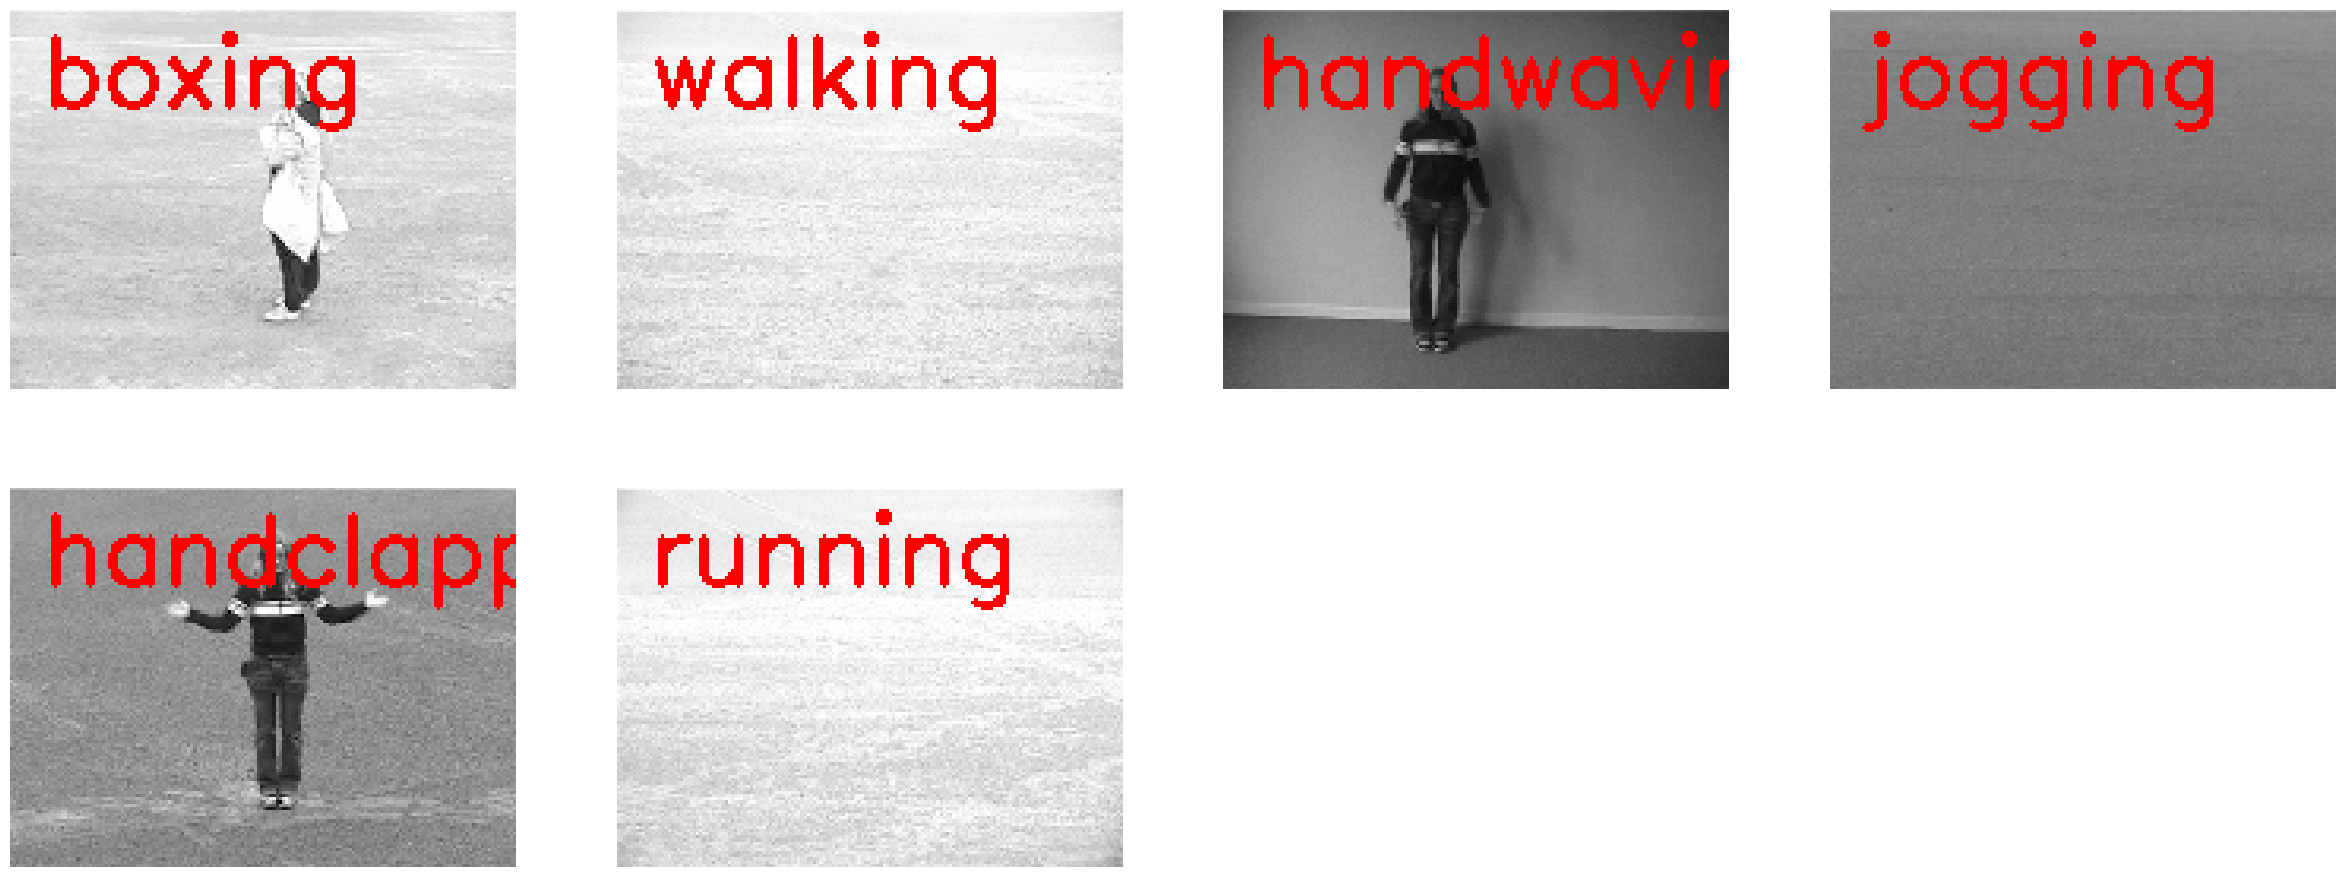

In [ ]:


# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

classes_list = []

all_classes_names = os.listdir('/content/gdrive/MyDrive/KTH dataset/train')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
    classes_list.append(selected_class_Name)
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'/content/gdrive/MyDrive/KTH dataset/train/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'/content/gdrive/MyDrive/KTH dataset/train/{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()

    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')



In [ ]:
image_height, image_width = 64, 64
dataset_directory= "/content/gdrive/MyDrive/KTH dataset"
print(classes_list)
model_output_size = len(classes_list)

['boxing', 'walking', 'handwaving', 'jogging', 'handclapping', 'running']


In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []

    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file
        success, frame = video_reader.read()

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()

    # returning the frames list
    return frames_list


In [ ]:
max_images_per_class=2500
def create_dataset(df):

    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')

        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory+'/'+df, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory+'/'+df, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)

        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index]* max_images_per_class)

        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
train_features, train_labels = create_dataset("train")
test_features, test_labels = create_dataset("test")

Extracting Data of Class: boxing
Extracting Data of Class: walking
Extracting Data of Class: handwaving
Extracting Data of Class: jogging
Extracting Data of Class: handclapping
Extracting Data of Class: running
Extracting Data of Class: boxing
Extracting Data of Class: walking
Extracting Data of Class: handwaving
Extracting Data of Class: jogging
Extracting Data of Class: handclapping
Extracting Data of Class: running


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels_train = to_categorical(train_labels)
one_hot_encoded_labels_test = to_categorical(test_labels)


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(train_features, one_hot_encoded_labels_train, test_size = 0.2, shuffle = True, random_state = 23)
labels_train.shape

(12000, 6)

In [ ]:

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.layers import Conv2D
from keras.layers import BatchNormalization, MaxPooling2D, GlobalAveragePooling2D


def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 25, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/25
2400/2400 [==============================] - 176s 73ms/step - loss: 1.7460 - accuracy: 0.2517 - val_loss: 3.6208 - val_accuracy: 0.1642
Epoch 2/25
2400/2400 [==============================] - 175s 73ms/step - loss: 1.6051 - accuracy: 0.2923 - val_loss: 2.3329 - val_accuracy: 0.2854
Epoch 3/25
2400/2400 [==============================] - 188s 79ms/step - loss: 1.4965 - accuracy: 0.3360 - val_loss: 1.5960 - val_accuracy: 0.3483
Epoch 4/25
2400/2400 [==============================] - 175s 73ms/step - loss: 1.4332 - accuracy: 0.3690 - val_loss: 1.6639 - val_accuracy: 0.3762
Epoch 5/25
2400/2400 [==============================] - 173s 72ms/step - loss: 1.3684 - accuracy: 0.3975 - val_loss: 2.4916 - val_accuracy: 0.3321
Epoch 6/25
2400/2400 [==============================] - 176s 73ms/step - loss: 1.3065 - accuracy: 0.4242 - val_loss: 1.2795 - val_accuracy: 0.4462
Epoch 7/25
2400/2400 [==============================] - 178s 74ms/step - loss: 1.2800 - accuracy: 0.4411 - val_loss: 1

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)


94/94 [==============================] - 14s 152ms/step - loss: 0.8553 - accuracy: 0.6123


In [ ]:
model_test_eval = model.evaluate(test_features, one_hot_encoded_labels_test)

469/469 [==============================] - 69s 146ms/step - loss: 1.5066 - accuracy: 0.3781


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

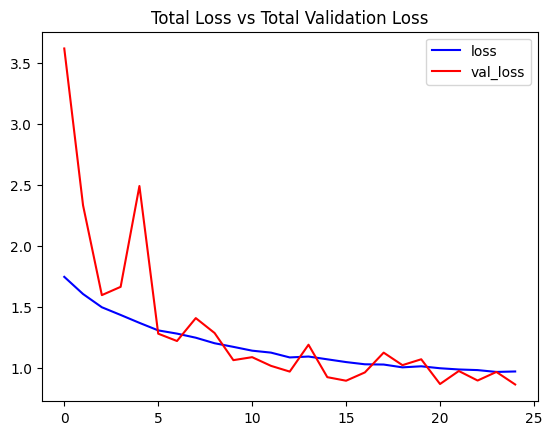

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


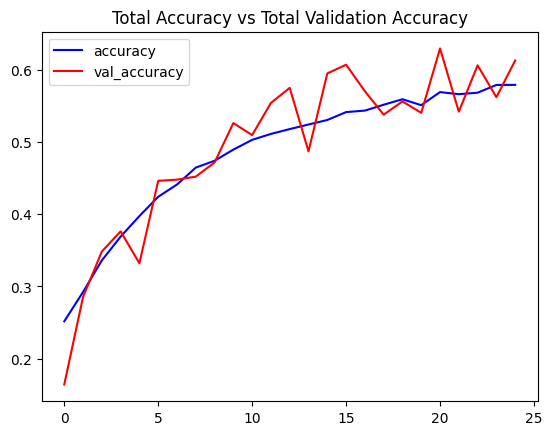

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):

    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = "float32")

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count):

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read()

        try:
          # Resize the Frame to fixed Dimensions
          resized_frame = cv2.resize(frame, (image_height, image_width))

        except:
          break


        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    print("PREDICTED CLASS-"np.argmax())

    # Closing the VideoCapture Object and releasing all resources held by it.
    video_reader.release()


In [ ]:

test_video_class = random.choice(os.listdir("/content/gdrive/MyDrive/KTH dataset/test/"))
test_video = random.choice(os.listdir(f"/content/gdrive/MyDrive/KTH dataset/test/{test_video_class}/"))

# Constructing The Input YouTube Video Path
input_video_file_path = f'/content/gdrive/MyDrive/KTH dataset/test/{test_video_class}/{test_video}'
print(input_video_file_path)

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

/content/gdrive/MyDrive/KTH dataset/test/running/person16_running_d2_uncomp.avi
1/1 [==============================] - 0s 20ms/step
CLASS NAME: jogging   AVERAGED PROBABILITY: 4.1e+01
CLASS NAME: walking   AVERAGED PROBABILITY: 3.1e+01
CLASS NAME: running   AVERAGED PROBABILITY: 2.3e+01
CLASS NAME: handwaving   AVERAGED PROBABILITY: 3.0
CLASS NAME: boxing   AVERAGED PROBABILITY: 1.6
CLASS NAME: handclapping   AVERAGED PROBABILITY: 0.56
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
